In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/AV_FacialAttributes')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py

def remove_datasets(f, *datasets):
  for dt in datasets:
    if dt in f:
      del f[dt]

# Load dataset
with h5py.File('data/dt.h5', 'r') as f:
    x, y = f['x'][:], f['y'][:]

In [ ]:
import numpy as np
from cv2 import cv2

x_gray = np.array([cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in x])
x_gray = x_gray.reshape(x_gray.shape + (1,))

with h5py.File('data/dt.h5', 'a') as f:
  # Remove old gray data
  remove_datasets(f, 'x_gray')
  # Save new gray data
  f.create_dataset('x_gray', data=x_gray)

In [ ]:
y_beard = y[:, :1]
y_moustache = y[:, 1:2]
y_facial_hairs = np.maximum(y_beard, y_moustache)
y_glasses = y[:, 2:]

with h5py.File('data/dt.h5', 'a') as f:
  # Remove old y data
  remove_datasets(f, 'y_beard', 'y_moustache', 'y_facial_hairs', 'y_glasses')
  # Save new y data
  f.create_dataset('y_beard', data=y_beard)
  f.create_dataset('y_moustache', data=y_moustache)
  f.create_dataset('y_facial_hairs', data=y_facial_hairs)
  f.create_dataset('y_glasses', data=y_glasses)

In [ ]:
from google.colab.patches import cv2_imshow
import h5py

im_index = 483

with h5py.File('data/dt.h5', 'r') as f:
  print(f.keys())
  cv2_imshow(f['x'][im_index])
  cv2_imshow(f['x_gray'][im_index])
  print('y_beard       ', f['y_beard'][im_index])
  print('y_moustache   ', f['y_moustache'][im_index])
  print('y_facial_hairs', f['y_facial_hairs'][im_index])
  print('y_glasses     ', f['y_glasses'][im_index])

In [235]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def has_beard(img):
  h, w, _ = img.shape
  _x, _y = (0, 0)

  mask = np.zeros_like(img)
  # create a white filled ellipse
  mask = cv2.ellipse(mask, (int((_x+w)/2), int((_y+h)/1.1)),(69,69), 0, 0, -180, (255,255,255), thickness=-1)
  _, counts = np.unique(mask, return_counts=True)
  ## mask = cv2.ellipse(mask, (int((_x+w)/2), _y+h),(69,69), 0, 0, -180, 255, thickness=-1)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  # Bitwise AND operation to black out regions outside the mask
  result = np.bitwise_and(img, mask)
  #Converting the final result as HSV inorder to detect colors
  hsv_img = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
  # Draws a rectangle
  cv2.rectangle(img, (_x, _y), (_x + w, _y + h), (255, 0, 0), 2)
  # Black Color
  low_black = np.array([94, 80, 2])
  high_black = np.array([126, 255, 255])
  ## low_black = 59
  ## high_black = 216
  MASK = cv2.inRange(hsv_img, low_black, high_black)
  #If the MASK only has black pixels caused due to no black colour in the original image
  c = cv2.countNonZero(MASK)
  return c / counts[1] > 0.08, result, MASK

In [4]:
import numpy as np
import cv2

def preprocessing(img):
  img = img.copy()
  h, w, _ = img.shape
  _x, _y = (0, 0)

  mask = np.zeros_like(img)
  # create a white filled ellipse
  mask = cv2.ellipse(mask, (int((_x+w)/2), int((_y+h)/1.1)),(69,69), 0, 0, -180, (255,255,255), thickness=-1)
  # Bitwise AND operation to black out regions outside the mask
  result = np.bitwise_and(img, mask)
  #Converting the final result as HSV inorder to detect colors
  hsv_img = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
  # Black Color
  low_black = np.array([94, 80, 2])
  high_black = np.array([126, 255, 255])
  MASK = cv2.inRange(hsv_img, low_black, high_black)
  MASK, *_ = cv2.split(MASK)
  mask, *_ = cv2.split(mask)
  indexes = np.nonzero(mask.flatten())
  return MASK.flatten()[indexes]

x_processed = np.array(list(map(preprocessing, x)))

In [8]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# def one_hot(src):
#   return np.array([[0, 1] if y_real[0] else [1, 0] for y_real in src])
# encoded_y = one_hot(y_beard)
y_beard = y[:, :1]
x_train, x_test, y_train, y_test = train_test_split(x_processed, y_beard.copy().flatten())
test set = 10% di no barba

clf = svm.SVC()
clf.fit(x_train, y_train)

SVC()

In [11]:
from sklearn.metrics import accuracy_score

y_true = y_test
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred, normalize=True)

0.9426934097421203

In [212]:
import cv2

y_beard = y[:, :1]

y_pred, y_true = [], []
flag = False
for i, (img, real_y) in enumerate(zip(x, y_beard)):
  # im = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
  im = img.copy()
  # b, g, r = [cv2.equalizeHist(ch) for ch in cv2.split(img.copy())]
  # im = cv2.merge([b, g, r])
  res, _, MASK = has_beard(im)
  y_pred.append(int(res))
  y_true.append(real_y[0])
  if y_pred[-1] and not y_true[-1] and not flag:
    print(i, cv2.countNonZero(MASK))
    flag = True

print(sum(np.array(y_pred) == np.array(y_true)) / len(x))
print(sum(np.array(y_pred)) / sum(np.array(y_true)))

442 1957
0.9410500460546515
0.015817223198594025


True


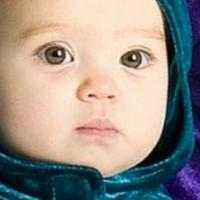

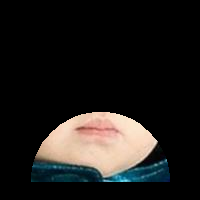

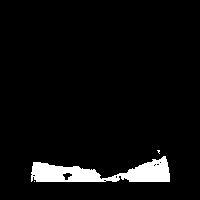

In [214]:
img = x[442 ]

#b, g, r = [cv2.equalizeHist(ch) for ch in cv2.split(img.copy())]
#im = cv2.merge([b, g, r])
# im = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
# im = _clahe.apply(im)
res, result, MASK = has_beard(img.copy())

print(res)
cv2_imshow(img)
cv2_imshow(result)
cv2_imshow(MASK)

Confusion matrix, without normalization
[[2303    0]
 [ 140    0]]


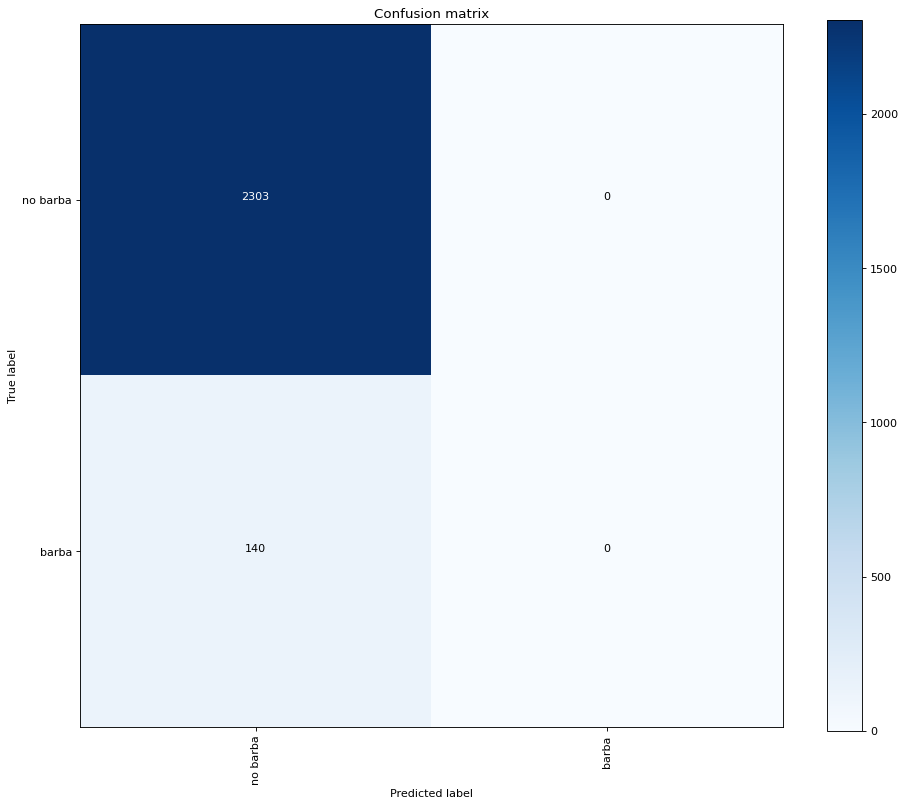

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(np.array(y_true), np.array(y_pred))
plot_confusion_matrix(cm, ['no barba', 'barba'],
                      normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)